In [9]:
import pandas as pd
import json
import os

json_files_directory = './交通态势可视分析/traffic/'
json_files = [os.path.join(json_files_directory, file) for file in os.listdir(json_files_directory) if file.endswith('.json')]

dataframes_list = []
for file in json_files:
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = pd.read_json(f, lines=True)
            df = pd.DataFrame(data)
            dataframes_list.append(df)
    except json.JSONDecodeError as e:
        print(f"Error reading {file}: {e}")

combined_df = pd.concat(dataframes_list, ignore_index=True)
combined_df.to_json('combined_json_file.json', orient='records', force_ascii=False)

剔除数据中type=-1 和seq = -1 的非法数据

In [10]:
import ijson
import json
from decimal import Decimal

def decimal_default(obj):
    """转换 Decimal 对象为字符串"""
    if isinstance(obj, Decimal):
        return str(obj)
    raise TypeError(f"不可序列化的对象类型：{type(obj)}")

def clean_large_json_file(input_file_path, output_file_path):
    """处理大型JSON文件，移除特定行，并更新文件"""
    # 打开输入文件进行增量读取
    with open(input_file_path, 'rb') as input_file:
        # 创建一个生成器，逐个产生条目
        objects = ijson.items(input_file, 'item')
        cleaned_objects = (obj for obj in objects if obj.get('type') != -1 and obj.get('seq') != -1)
        
        # 打开输出文件写入结果
        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            # 写入一个开头的列表括号
            output_file.write('[\n')
            first = True
            for obj in cleaned_objects:
                if not first:
                #     # 如果不是第一个元素，加上逗号分隔
                    output_file.write(',\n')
                else:
                    first = False
                # 将对象转换为 JSON 字符串并写入文件
                # 使用 decimal_default 函数来处理 Decimal 类型
                json_str = json.dumps(obj, ensure_ascii=False, default=decimal_default)
                output_file.write(json_str)
            # 写入结束的列表括号
            output_file.write('\n]')  


# 调用函数
# 假设你的原始文件名为 'large_data.json'。
# 清洗后的数据将写入 'cleaned_data.json'。
clean_large_json_file('combined_json_file.json', 'cleaned_data.json')

In [2]:
def count_lines_in_file(file_path):
    """计算文件中的行数"""
    line_count = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line_count += 1
    return line_count

# 假设你的 JSON 文件名为 'large_data.json'
line_count1 = count_lines_in_file('cleaned_data_v2.json')
# line_count2 = count_lines_in_file('combined_json_file.json')
print(f"文件共有 {line_count1} 行。")
# print(f"文件共有 {line_count2} 行。")

文件共有 16266422 行。


In [27]:
import ijson

def count_json_objects(file_path):
    """计算 JSON 文件中顶层对象的数量"""
    with open(file_path, 'rb') as file:
        objects = ijson.items(file, 'item')
        object_count = sum(1 for _ in objects)
    return object_count

# 假设你的 JSON 文件名为 'large_data.json'
object_count = count_json_objects('cleaned_data_v4.json')
print(f"JSON 文件中总共有 {object_count} 个对象。")

JSON 文件中总共有 15906394 个对象。


In [4]:
import ijson
import json

def clean_duplicate_types(input_file_path, output_file_path):
    # 统计每个 id 对应的 type 值数量
    type_counts = {}
    with open(input_file_path, 'rb') as input_file:
        objects = ijson.items(input_file, 'item')
        for obj in objects:
            obj_id = obj['id']
            obj_type = obj['type']
            if obj_id not in type_counts:
                type_counts[obj_id] = set()
            type_counts[obj_id].add(obj_type)
    
    # 找出有多个 type 的 id
    ids_to_remove = {obj_id for obj_id, types in type_counts.items() if len(types) > 1}
    
    # 重新读取数据并清除需要移除的 id 对应的数据
    with open(input_file_path, 'rb') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        objects = ijson.items(input_file, 'item')
        output_file.write('[')
        first = True
        for obj in objects:
            if obj['id'] not in ids_to_remove:
                if not first:
                    output_file.write(',\n')
                else:
                    first = False
                json_str = json.dumps(obj, ensure_ascii=False)
                output_file.write(json_str)
        output_file.write(']')

# 假设你的原始文件名为 'large_data.json'。
# 清洗后的数据将写入 'cleaned_data.json'。
clean_duplicate_types('cleaned_data.json', 'cleaned_data_v2.json')

In [4]:
import ijson
import json
import pandas as pd
# 将时间戳转换成标准时间格式
def convert_timestamp(ts):
    try:
        return pd.to_datetime(ts, unit='us').isoformat() #时间戳单位是us
    except ValueError:
        return None

def convert_json_timestamp(input_file_path, output_file_path):

    with open(input_file_path, 'rb') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
       objects = ijson.items(input_file, 'item')
       output_file.write('[')
       first = True
       for obj in objects:
           if 'time_meas' in obj:
               obj['time_standard'] = convert_timestamp(obj['time_meas'])
               del obj['time_meas']

           if not first:
               output_file.write(',\n')
           else:
               first = False
           json_str = json.dumps(obj, ensure_ascii=False)
           output_file.write(json_str)
       output_file.write(']')

convert_json_timestamp('cleaned_data_v2.json', 'cleaned_data_v3.json')

In [26]:
import ijson
import json
from datetime import datetime, timedelta
from dateutil.parser import parse
def time_clean(input_file_path, output_file_path):
    # 统计每个 id 对应的 type 值数量
    time_counts = {}
    # 创建一个空列表来存储符合条件的 id。
    ids_with_small_diff = []
    with open(input_file_path, 'rb') as input_file:
        objects = ijson.items(input_file, 'item')
        for obj in objects:
            obj_id = obj['id']
            obj_time = obj['time_standard']
            if obj_id not in time_counts:
                time_counts[obj_id] = set()
            time_counts[obj_id].add(obj_time)
    print('!!!')
        # 遍历timestamps字典。
    for id, timestamp_list in time_counts.items():
            # 转换字符串到datetime对象。
        datetime_list = [parse(ts) for ts in timestamp_list]
            
            # 计算最小和最大时间戳。
        min_timestamp = min(datetime_list)
        max_timestamp = max(datetime_list)
            
            # 计算最大和最小时间戳之间的差值。
        time_diff = max_timestamp - min_timestamp
            
            # 如果时间差小于5秒，添加id到列表中。
        if time_diff < timedelta(seconds=5):
            ids_with_small_diff.append(id)

        
        
    # 重新读取数据并清除需要移除的 id 对应的数据
    with open(input_file_path, 'rb') as input_file, open(output_file_path, 'w', encoding='utf-8') as output_file:
        objects = ijson.items(input_file, 'item')
        output_file.write('[')
        first = True
        for obj in objects:
            if obj['id'] not in ids_with_small_diff:
                if not first:
                    output_file.write(',\n')
                else:
                    first = False
                json_str = json.dumps(obj, ensure_ascii=False)
                output_file.write(json_str)
        output_file.write(']')

# 假设你的原始文件名为 'large_data.json'。
# 清洗后的数据将写入 'cleaned_data.json'。
time_clean('cleaned_data_v3.json', 'cleaned_data_v4.json')

!!!


#道路数据坐标转换

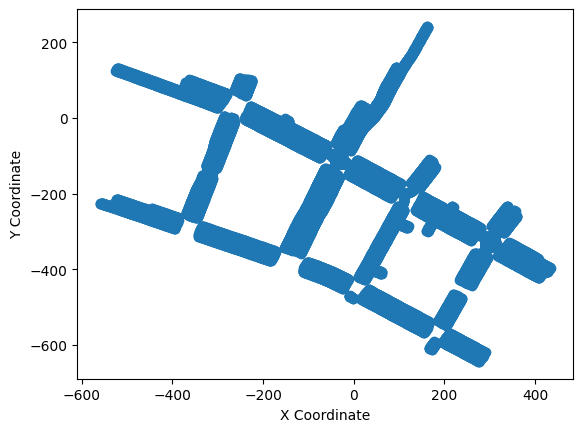

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
# 读取 GeoJSON 文件
with open('./交通态势可视分析/road2-12-9road/boundaryroad_with9road.geojson', 'r') as f:
    geojson_data = pd.read_json(f)

# 初始化 x 和 y 坐标列表
xs = []
ys = []

# 遍历 GeoJSON 中的要素
for feature in geojson_data['features']:
    geometry = feature['geometry']
    coords = geometry['coordinates']
    
    # 根据几何类型处理坐标
    if geometry['type'] == 'Point':
        # 仅提取 x 和 y 坐标
        x, y = coords[0], coords[1]
        xs.append(x)
        ys.append(y)
    elif geometry['type'] == 'LineString' or geometry['type'] == 'MultiPoint':
        for coord in coords:
            x, y = coord[0], coord[1]
            xs.append(x)
            ys.append(y)
    elif geometry['type'] == 'Polygon' or geometry['type'] == 'MultiLineString':
        for part in coords:
            for coord in part:
                x, y = coord[0], coord[1]
                xs.append(x)
                ys.append(y)
    elif geometry['type'] == 'MultiPolygon':
        for polygon in coords:
            for part in polygon:
                for coord in part:
                    x, y = coord[0], coord[1]
                    xs.append(x)
                    ys.append(y)

# 创建图形和坐标轴
fig, ax = plt.subplots()

# 在坐标轴上绘制点
ax.scatter(xs, ys)

# 设置坐标轴标签
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# 显示图形
plt.show()

In [5]:
import os
import json
import matplotlib.pyplot as plt

def plot_geojson(filename, ax):
    # 读取 GeoJSON 文件
    with open(filename, 'r') as f:
        geojson_data = json.load(f)

    # 遍历 GeoJSON 中的要素
    for feature in geojson_data['features']:
        geometry = feature['geometry']
        coords = geometry['coordinates']
        
        # 根据几何类型处理坐标
        if geometry['type'] == 'Point':
            x, y = coords[0], coords[1]
            ax.scatter(x, y)
        elif geometry['type'] in ['LineString', 'MultiPoint']:
            for coord in coords:
                x, y = coord[0], coord[1]
                ax.scatter(x, y)
        elif geometry['type'] in ['Polygon', 'MultiLineString']:
            for part in coords:
                for coord in part:
                    x, y = coord[0], coord[1]
                    ax.scatter(x, y)
        elif geometry['type'] == 'MultiPolygon':
            for polygon in coords:
                for part in polygon:
                    for coord in part:
                        x, y = coord[0], coord[1]
                        ax.scatter(x, y)

# 创建图形和坐标轴
fig, ax = plt.subplots()

# 指定文件夹路径
folder_path = './交通态势可视分析/road2-12-9road'

# 获取文件夹内所有的 .geojson 文件
geojson_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.geojson')]

# 循环处理每个文件
for filename in geojson_files:
    plot_geojson(filename, ax)

# 设置坐标轴标签
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# 显示图形
plt.show()